Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [102]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, homogeneity_completeness_v_measure
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

In [16]:
d= load_digits()
X= d.data
y= d.target

In [18]:
X.shape

(1797, 64)

**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

<Figure size 432x288 with 0 Axes>

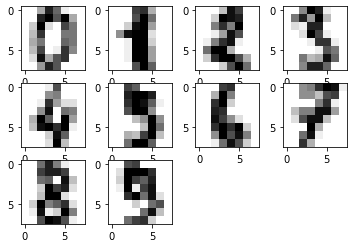

In [42]:
plt.gray()
fig = plt.figure()
for i in range (10):
    plt.subplot(3, 4, i+1)
    plt.imshow(d.images[i], cmap=plt.cm.gray_r)
plt.show()

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [76]:
AC21 = AgglomerativeClustering(n_clusters= 10).fit_predict(X)
KM21 = KMeans(n_clusters=10, n_init= 100, random_state= 42).fit_predict(X)
print ('AgglomerativeClustering-', len(AC21), ', KMeans-', len(KM21))

AgglomerativeClustering- 1797 , KMeans- 1797


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

<Figure size 432x288 with 0 Axes>

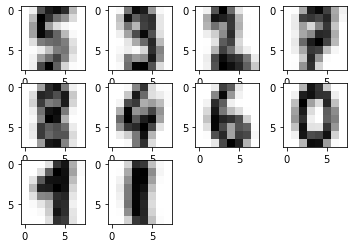

In [70]:
plt.gray()
fig = plt.figure()
for i in range (10):
    plt.subplot(3, 4, i+1)
    plt.imshow(np.mean(X[AC21==i], axis=0).reshape(8,8), cmap=plt.cm.gray_r)
plt.show()


<Figure size 432x288 with 0 Axes>

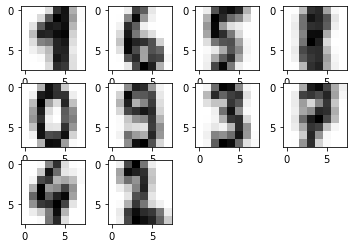

In [71]:
plt.gray()
fig = plt.figure()
for i in range (10):
    plt.subplot(3, 4, i+1)
    plt.imshow(np.mean(X[KM21==i], axis=0).reshape(8,8), cmap=plt.cm.gray_r)
plt.show()

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

In [79]:
KM23 = []
AC23 = []

for i in range(2, 21):
    km= KMeans(n_clusters=i, n_init= 100, random_state= 42)
    km.fit_predict(X)
    KM23.append(silhouette_score(X, km.labels_))
    ac = AgglomerativeClustering(n_clusters= i)
    ac.fit_predict(X)
    AC23.append(silhouette_score(X, ac.labels_))

Text(0, 0.5, 'Силуэт')

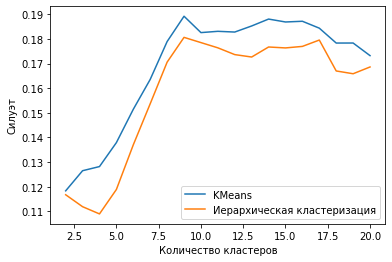

In [87]:

plt.plot(range(2, 21), KM23)

plt.plot(range(2, 21), AC23)
plt.legend(['KMeans', 'Иерархическая кластеризация'])
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')

**Судя по графикам, максимальное значение силуэта при К=9.**

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

In [94]:
KM24 = []
AC24 = []

for i in range(2, 21):
    km= KMeans(n_clusters=i, n_init= 100, random_state= 42)
    km.fit_predict(X)
    KM24.append(homogeneity_completeness_v_measure(y, km.labels_)[2])
    ac = AgglomerativeClustering(n_clusters= i)
    ac.fit_predict(X)
    AC24.append(homogeneity_completeness_v_measure(y, ac.labels_)[2])

Text(0, 0.5, 'V -мера')

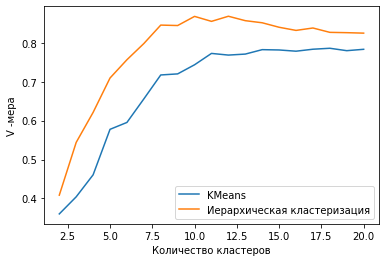

In [96]:
plt.plot(range(2, 21), KM24)

plt.plot(range(2, 21), AC24)
plt.legend(['KMeans', 'Иерархическая кластеризация'])
plt.xlabel('Количество кластеров')
plt.ylabel('V -мера')

**Максимальное значение V- меры при К=9 для Иерархической кластеризации, и К= 18 для KMeans.**

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [99]:
com = [2,5,10,20]
KM31 = []
AC31 = []
KM311 = []
AC311 = []

for j in com:
    Xt = TruncatedSVD(n_components= j).fit_transform(X)
    km= KMeans(n_clusters=10, n_init= 100, random_state= 42)
    km.fit_predict(Xt)
    KM311.append(homogeneity_completeness_v_measure(y, km.labels_)[2])
    ac = AgglomerativeClustering(n_clusters= 10)
    ac.fit_predict(Xt)
    AC311.append(homogeneity_completeness_v_measure(y, ac.labels_)[2])
    KM31.append(silhouette_score(Xt, km.labels_))
    AC31.append(silhouette_score(Xt, ac.labels_))

Text(0, 0.5, 'Силуэт')

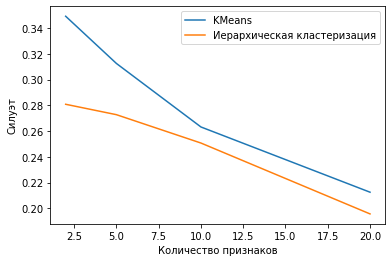

In [100]:
plt.plot(com, KM31)

plt.plot(com, AC31)
plt.legend(['KMeans', 'Иерархическая кластеризация'])
plt.xlabel('Количество признаков')
plt.ylabel('Силуэт')

Text(0, 0.5, 'V -мера')

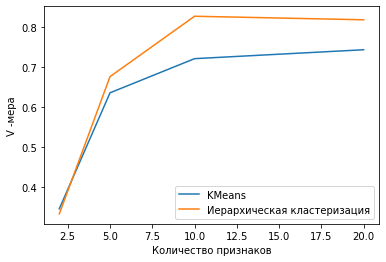

In [101]:
plt.plot(com, KM311)

plt.plot(com, AC311)
plt.legend(['KMeans', 'Иерархическая кластеризация'])
plt.xlabel('Количество признаков')
plt.ylabel('V -мера')

**Как видно из графиков силуэт с такими признаками получился лучше, а V-мера - хуже.**

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [104]:
XtSNE = TSNE(n_components= 2).fit_transform(X)

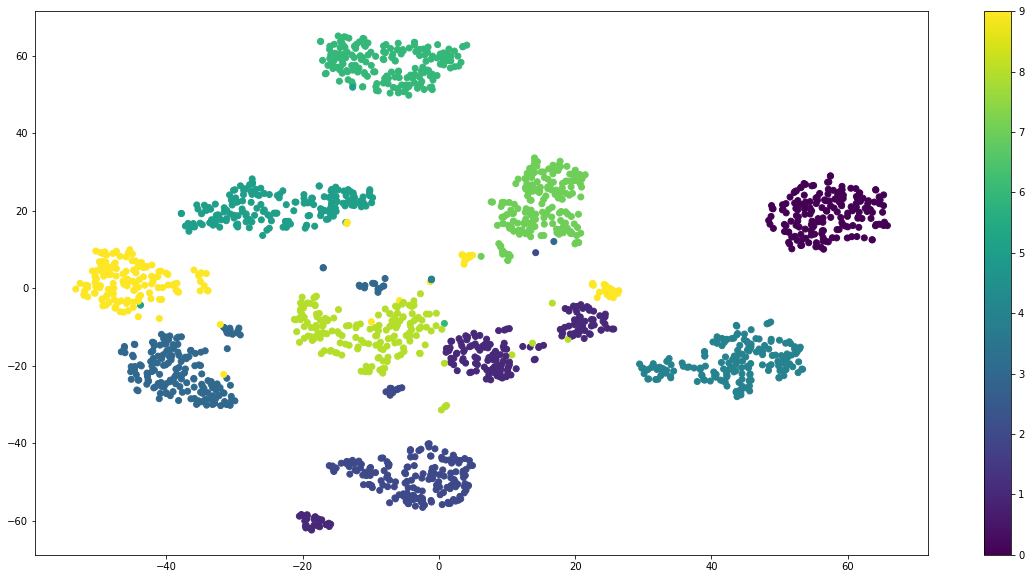

In [113]:
plt.figure(figsize=(20,10))
plt.scatter(XtSNE[:,0], XtSNE[:,1], c=y, cmap='viridis')
plt.colorbar();  # show color scale

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [114]:
km= KMeans(n_clusters=10, n_init= 100, random_state= 42)
km.fit_predict(XtSNE)
ac = AgglomerativeClustering(n_clusters= 10)
ac.fit_predict(XtSNE)
print('Силуэт KMeans', silhouette_score(XtSNE, km.labels_))
print('Силуэт AgglomerativeClustering', silhouette_score(XtSNE, ac.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y, km.labels_)[2])
print('V-мера AgglomerativeClustering', homogeneity_completeness_v_measure(y, ac.labels_)[2])


Силуэт KMeans 0.6376748
Силуэт AgglomerativeClustering 0.6373878
V-мера KMeans 0.9023277261153904
V-мера AgglomerativeClustering 0.9100177821951092


**Оба значения увеличились, а так же разница между 2 типами кластеризации стала незначительной.**

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

<Figure size 432x288 with 0 Axes>

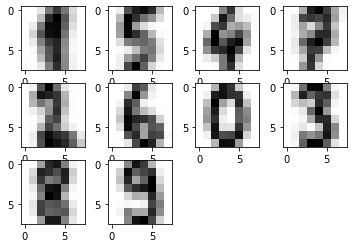

In [117]:
#V-мера AgglomerativeClustering

AC35 = AgglomerativeClustering(n_clusters= 10).fit_predict(XtSNE)

plt.gray()
fig = plt.figure()
for i in range (10):
    plt.subplot(3, 4, i+1)
    plt.imshow(np.mean(X[AC35==i], axis=0).reshape(8,8), cmap=plt.cm.gray_r)
plt.show()

**9 кластеров получилось хорошо, а вот с 1 - не очень (это вызванно спецификой написания цифры).**

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**-Силуэт выходит выше у 𝐾  средних, а V-мера у иерархической кластеризации (это логично из методов работы кластеризаций), соответственно более полный результат даёт иерархическая кластеризация ( за счёт построения Бинарного деревао кластеров). Зависимость количества кластеров на критерии в 2 методах ведут себя похоже, ростут до порогового значения, а потом медленно начинают падать.
-Снижая размерность в 2-х методах удается значительно повысить качество работы, а так же разница между оценками критериев в иерархической кластеризации и алгоритме  𝐾  средних становиться незначительной.**

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](http://scikit-learn.org/stable/datasets/index.html#downloading-datasets-from-the-mldata-org-repository). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [119]:
from sklearn.datasets import fetch_openml
X4, y4 = fetch_openml('mnist_784', version=1, return_X_y=True)

In [137]:
km4= KMeans(n_clusters=10, n_init= 100, random_state= 42)
km4.fit_predict(X4)

print('Силуэт KMeans', silhouette_score(X4, km4.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y4, km4.labels_)[2])

Силуэт KMeans 0.05869201052848778
V-мера KMeans 0.4997437873174721


In [124]:
XtSNE4 = TSNE(n_components= 2, n_jobs=-1).fit_transform(X4)

In [125]:
km= KMeans(n_clusters=10, n_init= 100, random_state= 42)
km.fit_predict(XtSNE4)

print('Силуэт KMeans', silhouette_score(XtSNE4, km.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y4, km.labels_)[2])

Силуэт KMeans 0.3907729
V-мера KMeans 0.7586735483091579


In [130]:
XtSNE43 = TSNE(n_components= 3, n_jobs=-1).fit_transform(X4)

In [136]:
km43= KMeans(n_clusters=10, n_init= 100, random_state= 42)
km43.fit_predict(XtSNE43)

print('Силуэт KMeans', silhouette_score(XtSNE43, km43.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y4, km43.labels_)[2])

Силуэт KMeans 0.3277492
V-мера KMeans 0.7505461987137119


In [133]:
km= KMeans(init='random',n_clusters=10, n_init= 100, random_state= 42)
km.fit_predict(XtSNE4)

print('Силуэт KMeans', silhouette_score(XtSNE4, km.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y4, km.labels_)[2])

Силуэт KMeans 0.39067805
V-мера KMeans 0.7576508040450556


In [132]:
km= KMeans(init='k-means++', n_clusters=10, n_init= 100, random_state= 42)
km.fit_predict(XtSNE4)

print('Силуэт KMeans', silhouette_score(XtSNE4, km.labels_))
print('V-мера KMeans', homogeneity_completeness_v_measure(y4, km.labels_)[2])

Силуэт KMeans 0.3907729
V-мера KMeans 0.7586735483091579


**В данных ограничения по методам получились следующие результаты, если бы можно было использовать pca и др. можно было бы достигнуть более высокого результата.**